Create a library of ACA PSF images using flight data from bright stars
---------------------------------------------------------------------------------

The `aca_psf_library` module will generate and access a set of PSF images generated from flight data.

In [1]:
%load_ext autoreload
%autoreload 1
%aimport aca_psf_library

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
from astropy.table import Table
from mica.stats import guide_stats
from mica.archive import aca_l0, aca_dark
from kadi import events

In [3]:
%matplotlib inline

In [4]:
import aca_psf_library

A set of bright stars is used to generate the mean images.  The code used to select stars is included below
as this set is still being refined.

In [5]:
#guide_stars = aca_psf_library.get_obs_slots()
def get_obs_slots():
    """                                                                                                          
    Use the guide star database to get a Table of long-ish ER observations with bright stars tracked well        
    I've used the old n100_warm_frac as a proxy for expected low-ish dark current, though the residuals          
    probably support this just as well.  This doesn't check for dither-disabled explicitly; I'm hoping we'd be   
    sensitive to that via the check that there is good centroid coverage within the observation.                 
    """
    gs = Table(guide_stats.get_stats())
    gs['dur'] = gs['npnt_tstop'].astype(float) - gs['kalman_tstart']
    ok = ((gs['obsid'] > 38000)
          & (gs['dur'] > 30000)
          & (gs['sz'] == '8x8')
          & (gs['aoacmag_mean'] < 6.5)
          & (gs['f_track'] > .99)
          & (gs['dy_std'] < .2)
          & (gs['dz_std'] < .2)
      & (gs['n100_warm_frac'] < .10))
    return gs[ok]
guide_stars = get_obs_slots()

In [6]:
guide_stars[['obsid', 'kalman_datestart', 'dur', 'tccd_mean', 'aoacmag_mean', 'yang', 'zang']]

obsid,kalman_datestart,dur,tccd_mean,aoacmag_mean,yang,zang
int64,bytes21,float64,float64,float64,float64,float64
60670,2003:187:03:07:03.912,38880.301,-14.7281799316,6.43790626526,-567.0,-281.0
60233,2004:136:22:02:52.791,33318.652,-15.4522504807,5.77071809769,997.0,2093.0
59460,2005:249:15:50:34.656,33658.951,-15.599395752,6.29500341415,-892.0,-1528.0
58649,2006:347:06:39:37.020,35946.751,-18.4623279572,6.12496805191,1345.0,2028.0
58426,2007:111:20:48:35.851,32979.377,-19.5828075409,6.19875335693,-1226.0,1299.0
58400,2007:130:09:18:00.328,37000.451,-19.5828094482,6.06250333786,-1850.0,-821.0
58300,2007:209:14:23:21.555,51259.228,-19.5828094482,6.12499761581,-675.0,1701.0
57818,2008:132:23:57:26.161,44755.602,-19.5885601044,6.31467580795,-972.0,-731.0
57775,2008:159:10:08:59.472,33413.9770001,-19.5828094482,6.43747711182,374.0,-1717.0


The library code is presently binning the first moment centroids from the observation into a 10x10 grid in a 1x1 pixel region in the center of the 8x8, stacking the images associated with the centroids centroid bins, and calculating mean/normalized pixel images for each stack.

The mean/normalized pixel image for each stack via this method is then averaged over the stars in the set.

A future improvement could include using improved centroids (ground pipeline) instead of first moment values.

In [7]:
master_psf, distributions, row_cens, col_cens = aca_psf_library.make_library(guide_stars)

The mean psf images for each of the binned centroid locations should have centroids that are in about the center
of each of the origin bins and these new centroids should definitely be *within* the original bins.  As a 10x10 grid within the center pixel was used, each PSF should have a centroid within .05 pixels of bin center.

In [8]:
def check_psf_centroids(psf):
    centroids = {}
    center_delta = {}
    for loc in psf:
        rc, cc = loc
        binsize = 1 / aca_psf_library.NBINS
        rc = (rc * binsize) + (binsize / 2) + aca_psf_library.LOW
        cc = (cc * binsize) + (binsize / 2) + aca_psf_library.LOW
        img = psf[loc]
        r, c, norm = aca_psf_library.centroid(np.array(img))
        centroids[loc] = (r, c)
        center_delta[loc] = (r - rc, c - cc)
    return centroids, center_delta

In [9]:
def plot_centroid_offsets(psf):
    centroids, center_delta = check_psf_centroids(psf)
    r_offset = np.array([center_delta[loc][0] for loc in center_delta])
    c_offset = np.array([center_delta[loc][1] for loc in center_delta])
    fig = plt.figure()
    ax = fig.gca()
    ax.set_aspect('equal')
    plt.plot(r_offset, c_offset, 'b.')
    plt.grid()

Centroid offsets for each bin of PSF made with the raw images


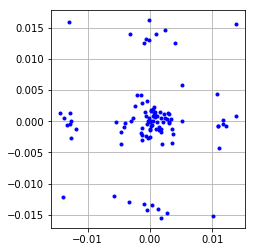

In [10]:
plot_centroid_offsets(master_psf)
print("Centroid offsets for each bin of PSF made with the raw images")

Do we need to background subtract the images used to make the PSF?

In [11]:
dwell = events.dwells.filter(obsid=guide_stars['obsid'][0])[0]
imgs = aca_l0.get_l0_images(dwell.start, dwell.stop, guide_stars['slot'][0])
imgs[0]

<ACAImage row0=116 col0=-53
array([[  16,   26,   45,   54,   36,   26,   64,   26],
       [  36,   74,  159,  282,  244,  121,   64,   45],
       [  54,  168,  606, 2876, 3760, 1242,  311,   92],
       [  74,  254, 1974, 7920, 9650, 5660,  805,  140],
       [  54,  150, 1489, 5090, 7332, 5944,  691,   92],
       [  16,   83,  235,  919, 3598, 1232,  226,   45],
       [  16,   16,   45,  178,  396,  226,   92,   36],
       [  16,    7,   26,   64,   74,   54,   36,   26]])>

The largest credible source of background, the CCD dark current, is not expected to be significant compared to these values, and a fundamental problem with the onboard background subtraction algorithm is that we expect the PSF to extend onto the 8 background pixels.

An future improvement to this work could include using the dark current map to background subtract the images used to make the PSF.

In [12]:
dc = aca_dark.get_dark_cal_image(dwell.start, select='nearest', aca_image=True)
row0 = imgs[0].row0
col0 = imgs[0].col0
# Extract the 8x8 from the dark cap map corresponding to img[0] and convert from e-/sec to expected DN
dc.aca[row0:(row0+8), col0:(col0+8)] * 1.7 / 5

<ACAImage row0=116 col0=-53
array([[ 1,  2,  3,  3,  4,  2, 38,  4],
       [ 4,  2,  1,  3,  2,  2,  2,  3],
       [ 2,  2,  2,  2,  2,  4,  2,  3],
       [ 3,  3,  3,  4,  2,  2,  2,  1],
       [21,  2,  2, 62,  5,  3,  2,  1],
       [ 2, 21,  2,  3,  4,  2,  2,  3],
       [ 5,  3,  1,  2,  3,  4,  0,  3],
       [13,  4,  1,  5,  4,  3,  1,  2]])>

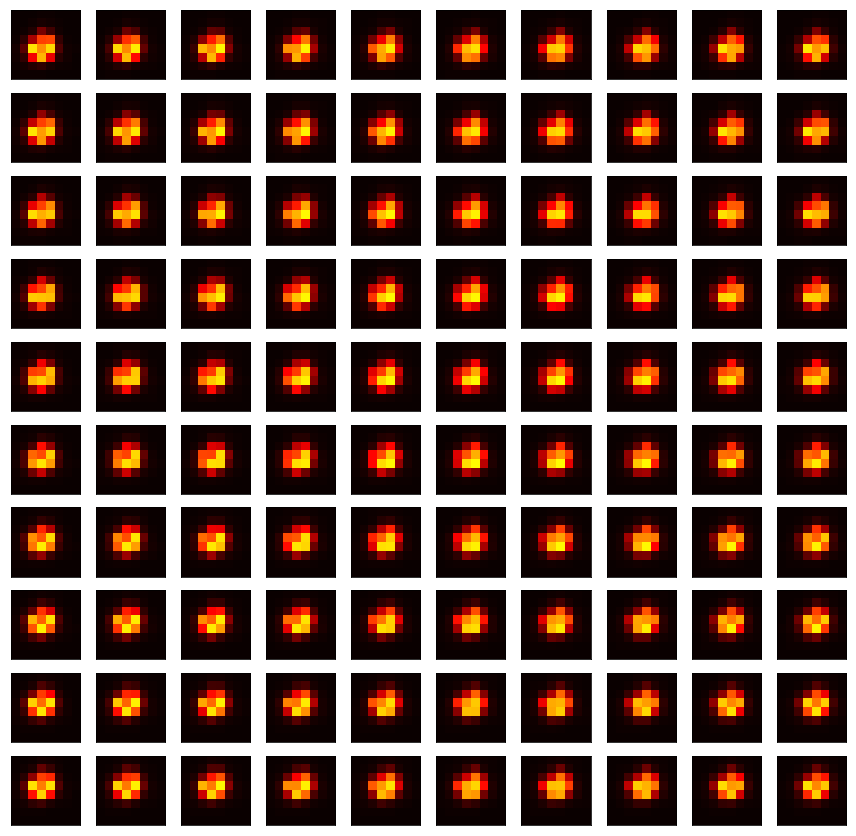

In [13]:
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i in range(9, -1, -1):
    for j in range(9, -1, -1):
        axes[i][j].imshow(master_psf[(i, j)], cmap='hot', origin='lower', vmin=0, vmax=.18)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])

The distribution of the number of images in each bin of the 10x10 sampling is captured in the "distributions" variable returned from make library.  

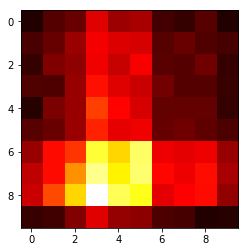

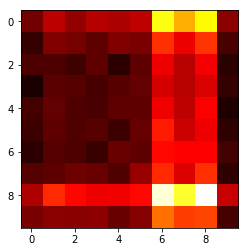

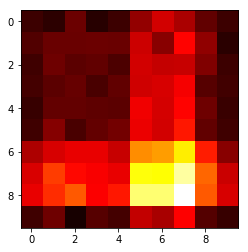

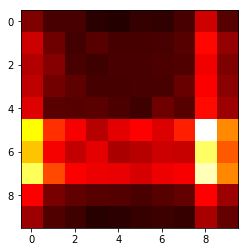

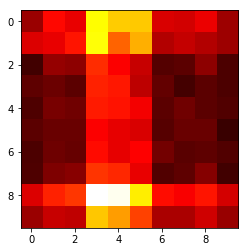

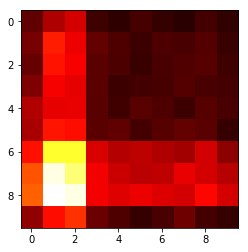

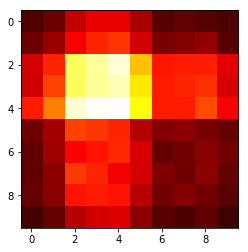

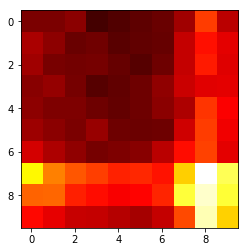

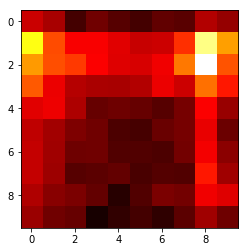

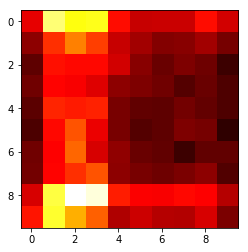

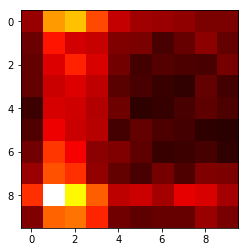

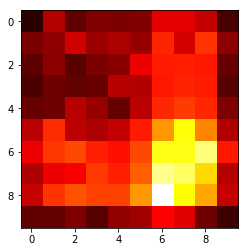

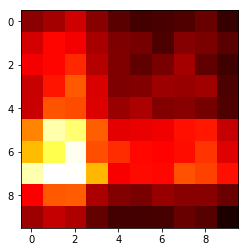

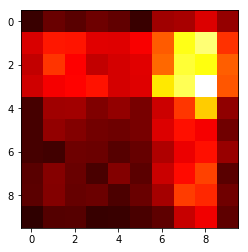

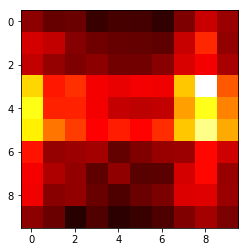

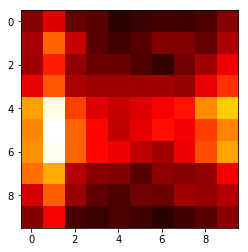

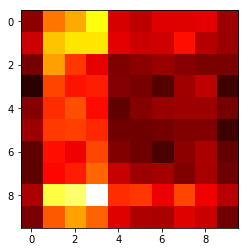

In [14]:
for stardist in distributions:
    plt.figure()
    plt.imshow(stardist, vmin=15, cmap='hot')